# Supervised & Unsupervised Topic Modelling

In [1]:
import arxiv
import string
import unidecode
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
try:
    from nltk.corpus import stopwords
except:
    import nltk
    nltk.download('stopwords')
finally:
    from nltk.corpus import stopwords

In [2]:
# constants
sns.set()
queries = [
    'automl', 'machinelearning', 'data', 'phyiscs','mathematics', 'recommendation system', 'nlp', 'neural networks'
]

## Load Data

In [3]:
def search_arxiv(queries: List[str], max_results: int = 100) -> pd.DataFrame:
    '''
    This function will search arxiv associated to a set of queries and store
    the latest 10000 (max_results) associated to that search.
    
    params:
        queries (List -> Str) : A list of strings containing keywords you want
                                to search on Arxiv
        max_results (Int) : The maximum number of results you want to see associated
                            to your search. Default value is 1000, capped at 300000
                            
    returns:
        This function will return a DataFrame holding the following columns associated
        to the queries the user has passed. 
            `title`, `date`, `article_id`, `url`, `main_topic`, `all_topics`
    
    example:
        research_df = search_arxiv(
            queries = ['automl', 'recommender system', 'nlp', 'data science'],
            max_results = 10000
        )
    '''
    d = []
    searches = []
    # hitting the API
    for query in queries:
        search = arxiv.Search(
          query = query,
          max_results = max_results,
          sort_by = arxiv.SortCriterion.SubmittedDate,
          sort_order = arxiv.SortOrder.Descending
        )
        searches.append(search)
    
    # Converting search result into df
    for search in searches:
        for res in search.results():
            data = {
                'title' : res.title,
                'date' : res.published,
                'article_id' : res.entry_id,
                'url' : res.pdf_url,
                'main_topic' : res.primary_category,
                'summary' : res.summary,
                'all_topics' : res.categories,
                'authors' : res.authors
            }
            d.append(data)
        
    d = pd.DataFrame(d)
    d['year'] = pd.DatetimeIndex(d['date']).year
    
    # change article id from url to integer
    unique_article_ids = d.article_id.unique()
    article_mapping = {art:idx for idx,art in enumerate(unique_article_ids)}
    d['article_id'] = d['article_id'].map(article_mapping)
    return d


In [4]:
# fetch data from arXiv
research_df = search_arxiv(
    queries = queries,
    max_results = 100
)
print(research_df.shape)

(648, 9)


In [5]:
research_df.head()

,title,date,article_id,url,main_topic,summary,all_topics,authors,year
0,Open Problems in Applied Deep Learning,2023-01-26 18:55:43+00:00,0,http://arxiv.org/pdf/2301.11316v1,cs.LG,This work formulates the machine learning mech...,"[cs.LG, cs.AI, cs.CV, cs.HC, cs.IR]",[Maziar Raissi],2023
1,RF+clust for Leave-One-Problem-Out Performance...,2023-01-23 16:14:59+00:00,1,http://arxiv.org/pdf/2301.09524v2,cs.NE,Per-instance automated algorithm configuration...,"[cs.NE, cs.AI]","[Ana Nikolikj, Carola Doerr, Tome Eftimov]",2023
2,Improvement of Computational Performance of Ev...,2023-01-12 15:59:04+00:00,2,http://arxiv.org/pdf/2301.05102v1,cs.LG,Resource-intensive computations are a major fa...,"[cs.LG, cs.NE, cs.PF]","[Nikolay O. Nikitin, Sergey Teryoshkin, Valeri...",2023
3,Data-driven photometric redshift estimation fr...,2022-12-30 13:01:41+00:00,3,http://arxiv.org/pdf/2212.14668v1,astro-ph.IM,Redshift measurement has always been a constan...,"[astro-ph.IM, astro-ph.CO]","[Felipe M F de Oliveira, Marcelo Vargas dos Sa...",2022
4,Multi-objective Tree-structured Parzen Estimat...,2022-12-13 17:33:02+00:00,4,http://arxiv.org/pdf/2212.06751v1,cs.LG,Hyperparameter optimization (HPO) is essential...,"[cs.LG, cs.AI]","[Shuhei Watanabe, Noow Awad, Masaki Onishi, Fr...",2022


## Data Cleaning

In [54]:
def remove_stopwords(text: str, sw: List[str] = stopwords.words('english')) -> str:
    '''
    This function will remove stopwords from the text
    
    Args:
        text: String of data you want to remove stopwords from
        sw: List of strings indicating the list of stopwords
        
    Returns:
        The input string with the stopwords removed.
    '''
    additional_sw = ['we', 'the', 'this', 'via']
    sw = sw + additional_sw
    return ' '.join([word for word in text.split() if word not in sw])
    
def remove_punctuation(text: str, punct: str = string.punctuation) -> str:
    '''
    This function will remove punctuations from the text.
    
    Args:
        text: String of data you want to remove punctuations from
        punct: String of punctuations
    
    Returns:
        The input string with the punctuations removed.
    '''
    cleaned_text = ''.join([char for char in text if char not in punct])
    return cleaned_text
    
def unicode(text: str) -> str:
    '''
    This function will make all the data unicoded. Meaning Â -> A
    
    Args:
        text: String of data you want to unicode
    
    Returns:
        The input string unicoded.
    '''
    return unidecode.unidecode(text)
    
def clean(text: str) -> str:
    '''
    This method will clean the input text through unidecoding and stopword and punctuation 
    removal.
    
    Args:
        text: String indicating the body of text you want to clean
    
    Returns:
        A string corresponding to the cleaned version of the input string.
    '''
    text = unicode(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text.lower()

In [55]:
%time research_df['cleaned_summary'] = research_df['summary'].apply(lambda x : clean(x))

CPU times: user 147 ms, sys: 2.15 ms, total: 149 ms
Wall time: 149 ms


In [56]:
research_df['cleaned_summary'].values[0]

'this work formulates machine learning mechanism bilevel optimization problem the inner level optimization loop entails minimizing properly chosen loss function evaluated training data this nothing wellstudied training process pursuit optimal model parameters the outer level optimization loop less wellstudied involves maximizing properly chosen performance metric evaluated validation data this call iteration process pursuing optimal model hyperparameters among many degrees freedom process entails model engineering eg neural network architecture design management experiment tracking dataset versioning augmentation the iteration process could automated automatic machine learning automl left intuitions machine learning students engineers researchers regardless route take need reduce computational cost iteration step direct consequence reduce carbon footprint developing artificial intelligence algorithms despite clean unified mathematical formulation iteration step bilevel optimization pro

In [39]:
' '.join([x for x in research_df['cleaned_summary'].values[0].split(' ') if x not in ['the', 'this']])

'work formulates machine learning mechanism bilevel optimization problem inner level optimization loop entails minimizing properly chosen loss function evaluated training data nothing wellstudied training process pursuit optimal model parameters outer level optimization loop less wellstudied involves maximizing properly chosen performance metric evaluated validation data call iteration process pursuing optimal model hyperparameters among many degrees freedom process entails model engineering eg neural network architecture design management experiment tracking dataset versioning augmentation iteration process could automated automatic machine learning automl left intuitions machine learning students engineers researchers regardless route take need reduce computational cost iteration step direct consequence reduce carbon footprint developing artificial intelligence algorithms despite clean unified mathematical formulation iteration step bilevel optimization problem solutions case specifi

In [36]:
%time research_df['summary_word_count'] = research_df['cleaned_summary'].astype('str').str.count(' ')

CPU times: user 8.93 ms, sys: 2.03 ms, total: 11 ms
Wall time: 10.9 ms


In [37]:
research_df.summary_word_count.describe()

count    648.000000
mean     112.183642
std       37.854744
min       10.000000
25%       86.750000
50%      111.000000
75%      137.000000
max      202.000000
Name: summary_word_count, dtype: float64

648 documents in total
647 documents have fewer than 200 words
99.8% documents have fewer than 200 words


Text(0.5, 0, 'Word_count')

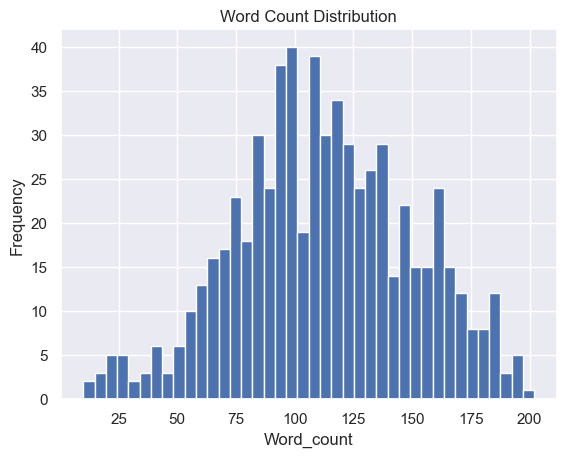

In [33]:
# word count distribution
print('{} documents in total'.format(research_df.shape[0]))
print('{} documents have fewer than 200 words'.format(research_df[research_df.summary_word_count<=199].shape[0]))
print('{}% documents have fewer than 200 words'.format(round(research_df[research_df.summary_word_count<=199].shape[0]/research_df.shape[0]*100, 1)))

ax = research_df.summary_word_count.plot.hist(bins=40)
ax.set_title("Word Count Distribution")
ax.set_xlabel('Word_count')

# Unsupervised Learning - LDA

In [58]:
import nltk
from gensim import models, corpora

In [27]:
article_summaries = research_df['cleaned_summary'].values
article_summaries = [[word for word in nltk.word_tokenize(article)] for article in article_summaries]

In [13]:
# Create a dictionary of all the words in the dataset
dictionary = corpora.Dictionary(article_summaries)

# Create a corpus
corpus = [dictionary.doc2bow(article) for article in article_summaries]

In [14]:
%%time
# Create an LDA model
lda = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=20)

CPU times: user 4.86 s, sys: 15.7 ms, total: 4.88 s
Wall time: 4.89 s


In [15]:
list_sorted_token = sorted(lda.id2word.cfs.items(), key=lambda item: item[1], reverse=True)

term_freq_df = pd.DataFrame(
    data={'term_freq': [value for (key, value) in list_sorted_token]}, 
    index = [lda.id2word[key] for (key, value) in list_sorted_token]
)

In [16]:
term_freq_df.head()

,term_freq
we,738
the,544
data,539
model,508
learning,464


In [60]:
tf_idf = models.TfidfModel(corpus=corpus)

In [62]:
df_body_topics_prob = pd.DataFrame(columns=['topic_'+str(i+1) for i in np.arange(lda.num_topics)])

for index, row in enumerate(lda.get_document_topics(corpus, minimum_probability=0.0)):
    #row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
    _, prob = zip(*row)
    df_body_topics_prob.loc[index] = list(prob)

In [63]:
df_body_topics_prob

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,0.000650,0.000650,0.000650,0.000650,0.000650,0.994154,0.000650,0.000650,0.000650,0.000650
1,0.000720,0.000720,0.469190,0.000720,0.000720,0.525051,0.000720,0.000720,0.000720,0.000720
2,0.001853,0.001853,0.001853,0.001853,0.001853,0.570859,0.001853,0.414314,0.001853,0.001853
3,0.000618,0.000618,0.000618,0.000618,0.216909,0.428707,0.000618,0.350059,0.000618,0.000618
4,0.001011,0.001011,0.001011,0.203054,0.001011,0.415016,0.374851,0.001011,0.001011,0.001011
...,...,...,...,...,...,...,...,...,...,...
643,0.001164,0.001164,0.001164,0.001164,0.001164,0.989522,0.001164,0.001164,0.001164,0.001164
644,0.725369,0.000856,0.000856,0.000856,0.000856,0.267786,0.000856,0.000856,0.000856,0.000856
645,0.000519,0.000519,0.000519,0.000519,0.000519,0.995333,0.000519,0.000519,0.000519,0.000519
646,0.993379,0.000736,0.000736,0.000736,0.000736,0.000736,0.000736,0.000736,0.000736,0.000736


In [71]:
topics_df = research_df.reset_index(drop=True).merge(
        df_body_topics_prob, how='left', right_index=True, left_index=True
)

In [74]:
df_body_topics = pd.DataFrame(index = ['topic_' + str(i+1) for i in np.arange(lda.num_topics)])

df_body_topics['n_documents'] = df_body_topics_prob[df_body_topics_prob>0.2].count(axis = 0)
#df_body_topics['coverage'] = df_body_topics_prob.sum(axis = 0)
df_body_topics['keywords'] = [
    ' '.join([word for word, prop in topic[1]]) for topic in lda.show_topics(
        num_topics=lda.num_topics, 
        num_words=50, formatted=False
    )
]

In [75]:
df_body_topics

,n_documents,keywords
topic_1,72,we quantum the show in space energy results th...
topic_2,47,we learning the data in model methods show pro...
topic_3,49,we the model data method models in number our ...
topic_4,87,we the data problem learning in model show sys...
topic_5,141,we the models in model learning automl using a...
topic_6,207,learning data model performance automl machine...
topic_7,72,models we tasks language nlp the performance i...
topic_8,32,ai models we green dual cancer data different ...
topic_9,26,optical tracking we beam the approach communic...
topic_10,92,we model the data system in learning models tr...


In [13]:
# Get the topic distribution for each document
for i, article in enumerate(article_summaries[0:10]):
    print(f"Article {i+1}: {lda.get_document_topics(corpus[i])}")

# Print the top words for each topic
print(lda.print_topics())

Article 1: [(3, 0.46642175), (4, 0.23049094), (6, 0.29011086)]
Article 2: [(3, 0.9944393)]
Article 3: [(3, 0.42782903), (6, 0.43481714), (9, 0.13027664)]
Article 4: [(3, 0.30521417), (5, 0.18022123), (9, 0.5097325)]
Article 5: [(3, 0.33438456), (6, 0.03671778), (7, 0.4607561), (9, 0.16465013)]
Article 6: [(0, 0.08745317), (3, 0.73005104), (9, 0.17600614)]
Article 7: [(1, 0.7006785), (9, 0.2929171)]
Article 8: [(3, 0.48065946), (7, 0.51125216)]
Article 9: [(2, 0.7006705), (3, 0.05207039), (9, 0.24218127)]
Article 10: [(3, 0.994794)]
[(0, '0.011*"we" + 0.005*"models" + 0.005*"the" + 0.004*"two" + 0.004*"in" + 0.004*"methods" + 0.004*"this" + 0.004*"language" + 0.004*"show" + 0.004*"data"'), (1, '0.008*"time" + 0.005*"data" + 0.005*"the" + 0.005*"model" + 0.005*"in" + 0.004*"this" + 0.004*"work" + 0.003*"proposed" + 0.003*"dynamics" + 0.003*"we"'), (2, '0.014*"we" + 0.007*"models" + 0.006*"language" + 0.006*"in" + 0.005*"model" + 0.005*"system" + 0.005*"learning" + 0.005*"using" + 0.005*"

## Visualization

In [14]:
# Create an empty dataframe
df = pd.DataFrame(columns=["article", "topic", "probability"])

# Loop over the articles and get the top 15 topics for each one
for i, article in enumerate(article_summaries):
    topics = lda.get_document_topics(corpus[i])
    topics = sorted(topics, key=lambda x: x[1], reverse=True)[:15]
    for topic in topics:
        df = df.append({"article": i, "topic": topic[0], "probability": topic[1]}, ignore_index=True)

In [15]:
df

,article,topic,probability
0,0.0,3.0,0.466409
1,0.0,6.0,0.290113
2,0.0,4.0,0.230501
3,1.0,3.0,0.994439
4,2.0,6.0,0.434814
...,...,...,...
902,643.0,9.0,0.992965
903,644.0,3.0,0.992618
904,645.0,3.0,0.994226
905,646.0,8.0,0.993177


In [16]:
# Get the list of top words for each topic
topics = lda.print_topics(num_words=5)

# Create a dictionary that maps the topic numbers to the topic names
topic_names = {}
for topic in topics:
    topic_num = topic[0]
    split_w = [w for w in topic[1].split('+')]
    topic_words = [w.split('*')[1] for w in split_w]
    topic_name = ",".join(topic_words)
    topic_names[topic_num] = topic_name

# Add a new column to the dataframe with the topic names
df["topic_name"] = df["topic"].map(topic_names)


In [17]:
df['topic'].value_counts()

3.0    169
9.0    126
2.0    115
8.0     91
4.0     86
7.0     75
0.0     74
5.0     71
6.0     60
1.0     40
Name: topic, dtype: int64

## Word Cloud

In [80]:
from wordcloud import WordCloud

In [81]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic, topn=50)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()

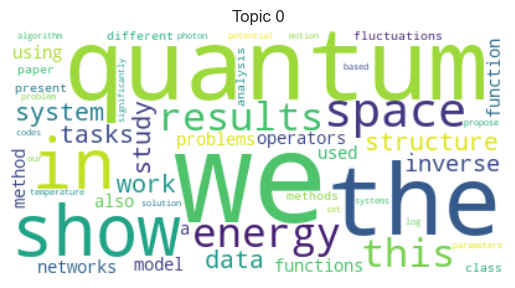

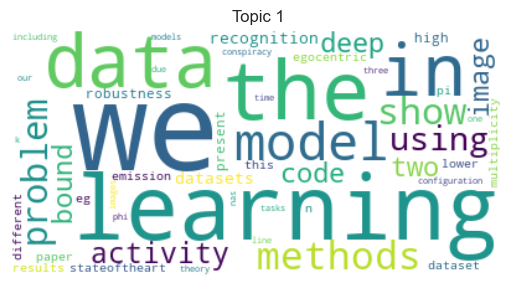

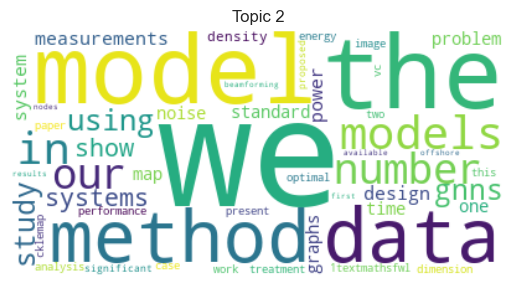

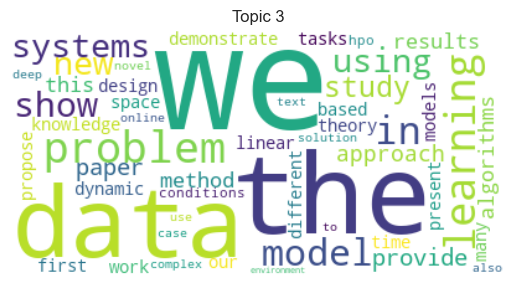

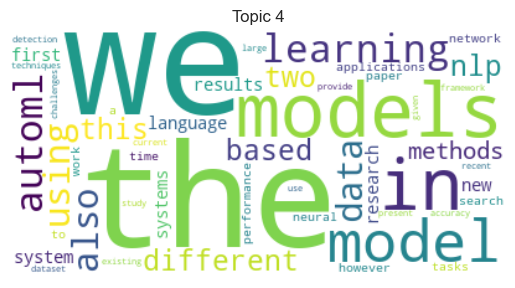

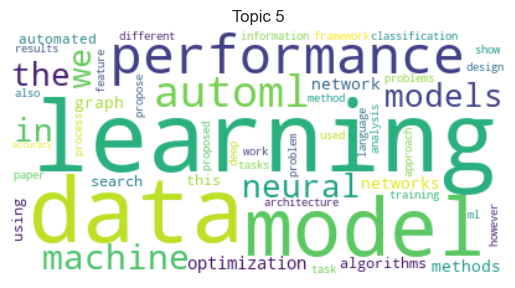

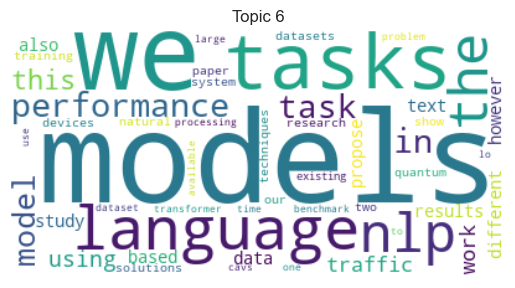

In [ ]:
for i in range (0,25):
    create_wordcloud(lda, topic=i)

## Topic Analysis

# Supervised Learning - Binary Classification

In [ ]:
# generate labels

## Evaluation

# Supervised Learning - Multi-Class Classification

---